In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader

In [3]:
from src.utils.__utils__ import *
from src.ssd.ssd_model import *
from src.dataset.VOC_dataset import *
from src.config.prior_box_cfg_SSD300 import *
from src.transform import __imgtools__, __boxtools__, augmentation
from src.ssd import ssd_prior
from src.train.one_cycle_multi import *
from src.config import prior_box_cfg_SSD300 as config
from src.ssd.ssd_preprocessing import TrainTransform, ValidTransform

In [4]:
img_size = 300
batch_size = 32

In [5]:
torch.cuda.set_device(2)

# Load data

In [6]:
IMG_PATH = Path('/data/xhan/Dropbox/USF MantaRay Data Share/resized_300')

In [7]:
train_bbox_multi_df = pd.read_csv('./data/train_anno.csv')
val_bbox_multi_df = pd.read_csv('./data/val_anno.csv')

In [8]:
train_bbox_multi_df.head()

,fn_orig,fn_new,label,bbox,bbox_300
0,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/USF MantaRay Data Share/res...,1 1,69 668 150 71 604 1108 71 68,19 116 42 13 168 193 19 12
1,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/USF MantaRay Data Share/res...,1,921 747 52 44,256 130 14 8
2,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/USF MantaRay Data Share/res...,1,737 391 111 179,205 68 30 31
3,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/USF MantaRay Data Share/res...,1,785 1206 50 39,218 210 14 7
4,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/USF MantaRay Data Share/res...,1,558 29 134 56,155 5 37 10


In [9]:
categories_bb = {0: 'background', 1: 'microfiber'}

In [10]:
center_variance = 0.1
size_variance = 0.2
iou_threshold = 0.1

priors = __boxtools__.generate_ssd_priors(specs, image_size=img_size, clip=True)
priors = torch.from_numpy(priors).float()
if torch.cuda.is_available:
    priors = priors.cuda(non_blocking=True)

In [11]:
train_transform = TrainTransform(
    config.image_size, config.image_mean, config.image_std)
val_transform = ValidTransform(
    config.image_size, config.image_mean, config.image_std)
target_transform = ssd_prior.MatchPrior(priors,
                                        config.center_variance,
                                        config.size_variance,
                                        config.iou_threshold)

In [25]:
voc_multibb_train = multiBboxDataset(IMG_PATH, train_bbox_multi_df, transform=None,
                                     target_transform=target_transform, 
                                     sz=img_size)

voc_multibb_valid = multiBboxDataset(IMG_PATH, val_bbox_multi_df, transform=None, 
                                     target_transform=target_transform,
                                     sz=img_size)

In [26]:
train_dl = DataLoader(voc_multibb_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_dl = DataLoader(voc_multibb_valid, batch_size=batch_size, num_workers=0, pin_memory=False)

In [27]:
X, y_label, y_bb = next(iter(train_dl))

In [28]:
torch.cuda.empty_cache()

In [29]:
y_bb

tensor([[[  6.7500,  21.6667,  -3.8107,  -9.4856],
         [  5.1770,  16.6176,  -5.1373, -10.8122],
         [  4.7730,  30.6413,  -5.5436,  -7.7527],
         ...,
         [ -3.5564,  -0.5394, -11.8017, -17.4766],
         [ -3.5167,  -1.0077, -11.8579, -14.3512],
         [ -6.6448,  -0.5333,  -8.6763, -17.5328]],

        [[ 13.5000,  25.2500,  -2.9892,  -6.0199],
         [ 10.3540,  19.3659,  -4.3158,  -7.3464],
         [  9.5459,  35.7089,  -4.7221,  -4.2870],
         ...,
         [ -2.1911,   0.1854, -10.9802, -14.0109],
         [ -2.1667,   0.3464, -11.0364, -10.8855],
         [ -4.0939,   0.1833,  -7.8548, -14.0671]],

        [[ 40.0833,  23.5000,  -3.4657,  -9.4856],
         [ 30.7425,  18.0237,  -4.7923, -10.8122],
         [ 28.3432,  33.2340,  -5.1986,  -7.7527],
         ...,
         [  3.1856,  -0.1685, -11.4567, -17.4766],
         [  3.1500,  -0.3149, -11.5129, -14.3512],
         [  5.9520,  -0.1667,  -8.3313, -17.5328]],

        ...,

        [[  1.0833, 

# LR finder

In [30]:
model = SSDNet(num_classes=2,
               im_shape=(config.image_size, config.image_size)).cuda()

In [31]:
lrs, losses = LR_range_finder_multibox(model, train_dl, priors, lr_low=1e-6, lr_high=1, epochs=2)

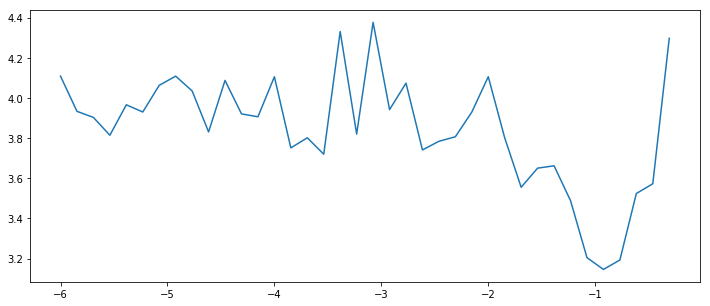

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot([np.log10(l) for l in lrs][:38], losses[:38])
plt.show()